#### 1. Prepare your data
A raw data directory is required. It contains a comma separated file (CSV) and FASTA nucleic acid files for different samples. The directory structure of raw data is shown below:
```
raw_data
│   meta_data.csv  
|   SAMPLE_1.fna
|   SAMPLE_2.fna
|   SAMPLE_3.fna
|   ...
```
Formats of the required files is shown below:
1. *meta_data.csv* format example:

| sample_id | label  |
|-----------|--------|
| SAMPLE_1  | feces  |
| SAMPLE_2  | tongue |
| SAMPLE_3  | feces  |
| SAMPLE_4  | skin   |
| ...       | ...    |

2. SAMPLE_1.fna format example:
```
>SAMPLE_1_1
GCGAGCGAAGTTCGGAATTACTGGGCGTAAAGGGTGTGTA
>SAMPLE_1_2
GCGAGCGTTGTTCGGAACCACTGGGCGTAAAGGGTGTGTA
>SAMPLE_1_3
GCGAGCGTTGTTCGGAATTACTGGGCGTAGAGGGTGTGTA
```

#### 2. Edit the configuration file
The user should edit the `config.py` to configure the model specs including the path to your data and the hyperparameters of the model. The following parameters should be edited based on your data. Please also carefully review the `config.py` file's comments for more detailed information for the rest of parameters and make sure you also modified them accordingly.
1. `in_dir`: the absolute path to the raw data directory (should be created by the user in advance).
2. `out_dir`: the absolute path to the processed data directory (should be created by the user in advance and files will be generated by this program).
3. `num_train_samples_per_cls`: the number of training sample per class. Note that the rest of samples will be automatically placed in the testing set used for evaluation. If you decide to use all the data for training, then the testing set will be empty and then hence the downstreaming evaluation command won't work.
4. `SEQLEN`: sequence length.
5. `BASENUM`: the number of unique characters (nucleotides/amino acids) (e.g., for DNA reads, there are 4 major bases for DNA sequence input, therefore you can set `BASENUM` to 4).
6, `Ty`: the number of target classes (`Ty` >= 2).
7. `save_model_path`: the absolute path to the saved model directory (should be created by the user in advance).
8. `n_workers`: this is used for a Keras function. It defines the number of threads generating batches in parallel. According to Kera, batches are computed in parallel on the CPU and passed on the fly onto the GPU for neural network computations.

#### 3. Load modules

In [1]:
import keras
import numpy as np
from sequence_attention import SeqAttModel, preprocess_data, preprocess_data_pickle
from sequence_attention import DataGenerator, DataGeneratorUnlabeled, DataGeneratorPickle, DataGeneratorUnlabeledPickle
from config import Config

Using TensorFlow backend.


#### 4. Load the configuration information from `config.py`

In [2]:
opt = Config()

#### 5. Preprocess the data

There are three different ways to prepare the data: 
1. split each fna file into files that contain one read per file. Then the data generator for the deep learning model can quickly load reads and construct a batch of data. However, it can be very slow to split reads into individual files when you have millions of reads to split; 
2. convert each fna file to a pickle file with a python dictionary data structure (key is the unique sequence identifier and value is the actual sequence). Then the data generator can load a pickle file and look up for a read and construct a batch of data. It is way faster than the first method in preprocessing part but can be slower when the data generator constructs the training/testing batch. 
3. The fastest way is, of course, training and testing your model without using the data generator. Instead, permitted by the computer memory, users can load all the training data in memory and directly fit the model. In this way, there will be no additional I/O process. When designing this tool, we don't make any assumption on the computer memory at the user's disposal, therefore, this demo focuses on the second preprocessing method since it covers the most use cases. But if the users do have enough memory, they are more than welcome to fit the model without the generator function. We will talk about additional information about the third method in the model training step.

In [3]:
preprocess_data_pickle(opt)

22-Aug-21 11:17:13 - Processing raw data: 0.0% completed.
22-Aug-21 11:17:13 - Processing raw data: 10.0% completed.
22-Aug-21 11:17:13 - Processing raw data: 20.0% completed.
22-Aug-21 11:17:14 - Processing raw data: 30.0% completed.


#### 6. Load metadata and initialize the deep learning model

In [4]:
import pickle
label_dict = pickle.load(open('{}/label_dict.pkl'.format(opt.out_dir), 'rb')) 
sample_to_label, read_meta_data = pickle.load(open('{}/meta_data.pkl'.format(opt.out_dir), 'rb'))
partition = pickle.load(open('{}/train_test_split.pkl'.format(opt.out_dir), 'rb')) 
seq_att_model = SeqAttModel(opt)

22-Aug-21 11:17:19 - Model initialized.


You can check the summary of the model by running the following command

In [5]:
seq_att_model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 4)       0                                            
__________________________________________________________________________________________________
convblock_0_cnv0 (Conv1D)       (None, 100, 256)     9472        input_1[0][0]                    
__________________________________________________________________________________________________
convblock_0_bn0 (BatchNormaliza (None, 100, 256)     1024        convblock_0_cnv0[0][0]           
__________________________________________________________________________________________________
convblock_0_a0 (Activation)     (None, 100, 256)     0           convblock_0_bn0[0][0]            
__________________________________________________________________________________________________
resblock_0

#### 7. Prepare the data generator for training and testing

In [6]:
training_generator = DataGeneratorPickle(partition['train'], sample_to_label, label_dict, 
                                   dim=(opt.SEQLEN,opt.BASENUM), batch_size=opt.batch_size, shuffle=opt.shuffle)
testing_generator = DataGeneratorPickle(partition['test'], sample_to_label, label_dict, 
                                   dim=(opt.SEQLEN,opt.BASENUM), batch_size=opt.batch_size, shuffle=opt.shuffle)


###### Note: training without the generator (1)
As mentioned in step 5, if you can fit all your training data in memory, you can directly train your model without using the slow data generator which does a lot of I/O operations on the fly. Take the training step as an example, all you need to prepare is an X and a y variable for training sequence data and training label data. Below, I show what the X and y look like using one batch of my demo training data. As you can see, the X is simply 1024 by 100 by 4 NumPy array. In your case, the first dimension (1024) should be the total number of training reads/sequences. Say you want to use 50 samples for training and each sample on average has 20,000 reads, then you will have around 100,000 reads for training in total. The second dimension (100) is the read/sequence length. You can trim all your reads to the same length or pad zeros to the end so that all the reads are in the same length. The last dimension (4) corresponds to the number of unique characters in your data. Say you are dealing with DNA sequences with no ambiguity, there will be 4 characters, `ACGT`. We are performing one hot coding. So nucleotide `A` is coded as $[1, 0, 0, 0]$, `G` is codes as $[0, 0, 1, 0]$.

In [7]:
X, y = training_generator.__getitem__(0)

In [8]:
X.shape

(1024, 100, 4)

In [9]:
y.shape

(1024,)

#### 8. Train and evluate the model
If your meomory is limited, data generator load only a subset of the whole training data into memory for training. This process costs additional I/0 operations in exchange for less memory consumption.

In [10]:
seq_att_model.train_generator(training_generator, n_workers=opt.n_workers)

In [11]:
seq_att_model.evaluate_generator(testing_generator, n_workers=opt.n_workers)

###### Note: training without the generator (2)
For those of you who have enoguh memory, you can avoid additional I/O operations by training the model without the data generator. Once you have the training data X and y ready (see ***Note: training without the generator (1)*** for details), you can run the following command to train your model directly without the data generator function. This is the fastest training method given your training data fits into your memory.

In [12]:
seq_att_model.model.fit(X, y, batch_size=opt.batch_size, epochs=opt.epochs)

Epoch 1/1
1024/1024 [==============================] - 15s 15ms/step - loss: 0.7214 - acc: 0.5127


#### 9. Model interpretation and sequence visualization
This step is exploratory and completely depends on you. To get started, please review the following data requirements:

1. Prepare the X_visual (N by SEQ_LEN by NUMBASE) in *numpy array*, see also ***Note: training without the generator (1)***
2. y_visual (phenotypic labels in integers) in *numpy array*, use `label_dict` as the label to integer map.
3. a list of taxonomic labels of those sequences (e.g., genus level labels as python strings). 

Once you have the data ready, run the following commands to plot embedding and attention weights visualization figures.

###### Note: we provide a toy example of how it works and what results it produces in the appendix section below.

In [13]:
prediction, attention_weights, sequence_embedding = seq_att_model.extract_weigths(X_visual)
from sequence_attention import SeqVisualUnit
idx_to_label = {label_dict[label]: label for label in label_dict}
seq_visual_unit = SeqVisualUnit(X_visual, y_visual, idx_to_label, taxa_label_list, 
                                prediction, attention_weights, sequence_embedding, 'Figures')

seq_visual_unit.plot_embedding()
## Let's say you want to plot the attention weights of "Prevotella" reads
seq_visual_unit.plot_attention('Prevotella')

In the code snippet above, we also need , *label_dict* (phenotypic labels to integer dictionary saved in `opt.out_dir/label_dict.pkl` by the previous steps.

#### Appendix: a pretrain model and visualization dataset
This model is trained on American Gut dataset to predict five body sites on read level, namely, *feces*, *nostril*, *skin of hand*, *skin of head*, *tongue*. In this section, we demonstrate how we can use the `sequence_attention` module to extract and visualize embedded vectors and sequence attention weights on read level. The toy visualization data are reads classified as *Bacteroides*, *Corynebacterium*, *Faecalibacterium*, *Neisseria*, *Prevotella*, *Propionibacterium* by RDP collected from different body sites.

In [14]:
import keras
import numpy as np
from sequence_attention import SeqAttModel, preprocess_data, preprocess_data_pickle
from sequence_attention import DataGenerator, DataGeneratorUnlabeled, DataGeneratorPickle, DataGeneratorUnlabeledPickle
from config import Config

opt = Config()

In [15]:
opt.Ty=5
opt.if_lstm=2
opt.n_lstm_node=64

In [16]:
seq_att_model = SeqAttModel(opt)

22-Aug-21 11:19:52 - Model initialized.


In [17]:
seq_att_model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 4)       0                                            
__________________________________________________________________________________________________
convblock_0_cnv0 (Conv1D)       (None, 100, 256)     9472        input_2[0][0]                    
__________________________________________________________________________________________________
convblock_0_bn0 (BatchNormaliza (None, 100, 256)     1024        convblock_0_cnv0[0][0]           
__________________________________________________________________________________________________
convblock_0_a0 (Activation)     (None, 100, 256)     0           convblock_0_bn0[0][0]            
__________________________________________________________________________________________________
resblock_0

In [18]:
seq_att_model.model.load_weights('demo_model_weights.h5')

In [19]:
import pickle
[X_visual, y_visual, label_dict, taxa_label_list] = pickle.load(open('visualization_toy_data.pkl', 'rb'))

###### Note: merging skin related classes (2)

The model was trained on 5 body sites and three of them, *nostril*, *skin of hand*, *skin of head*, are relative hard to differentiate from each other. In this demo, we merge *nostril*, *skin of hand*, *skin of head* to skin so that we can produce better visualization.

In [20]:
reduced_label_to_idx = {'feces': 0, 'skin': 1, 'tongue': 2}
reduced_idx_to_label = {reduced_label_to_idx[reduced_label]: reduced_label for reduced_label in reduced_label_to_idx}
idx_to_reduced_idx = {0: 1, 1: 0, 2: 1, 3: 2, 4: 1}

In [21]:
y_visual_reduced = np.array([idx_to_reduced_idx[idx] for idx in y_visual])

In [22]:
reduced_label_to_idx

{'feces': 0, 'skin': 1, 'tongue': 2}

In [23]:
np.unique(y_visual_reduced)

array([0, 1, 2])

###### Visualization

22-Aug-21 11:20:30 - Weights extraction started: extract weights for 4000 sequences
22-Aug-21 11:20:40 - Weights extraction completed.
22-Aug-21 11:20:40 - Visualization object initialized: Read2Phenotype Accuracy: 0.8850.


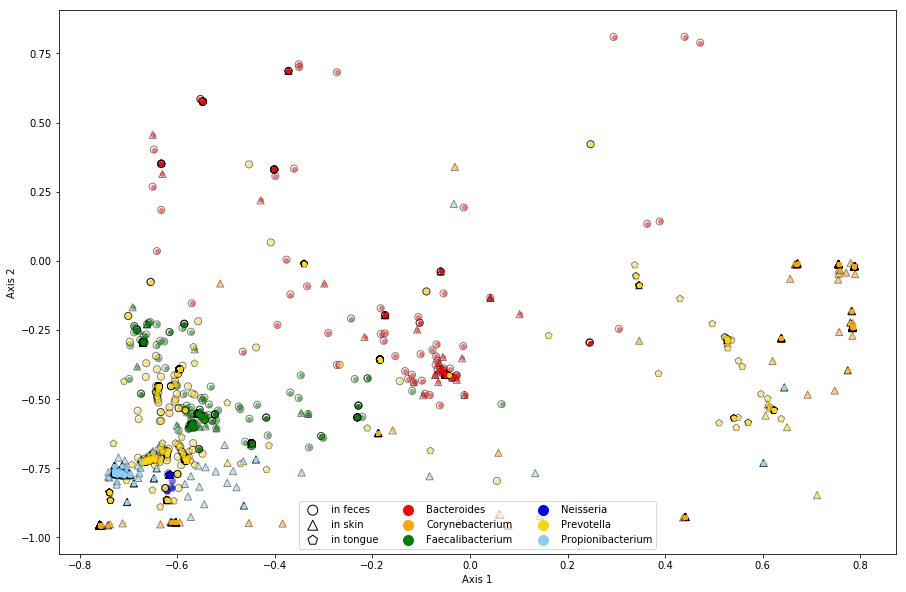

22-Aug-21 11:20:44 - Classes to be visualized: tongue, feces.
22-Aug-21 11:20:44 - Attention Visualization: Plotting Prevotella in tongue.


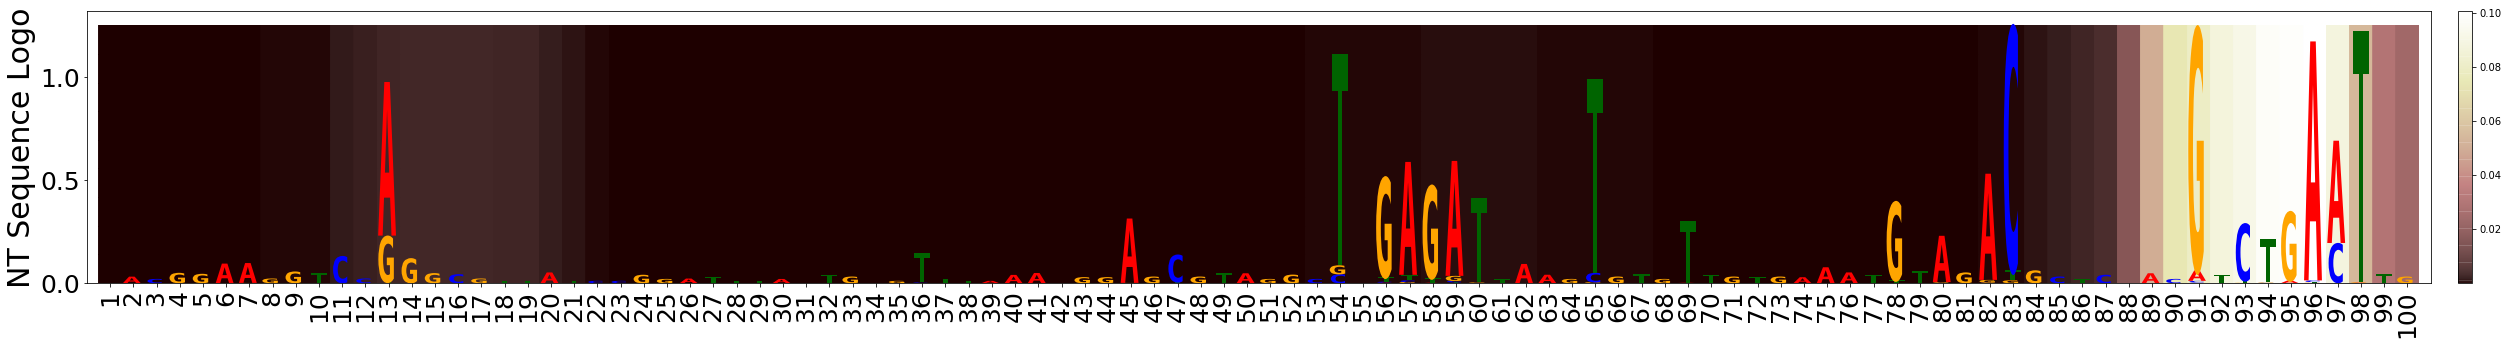

22-Aug-21 11:20:50 - Attention Visualization: Plotting Prevotella in feces.


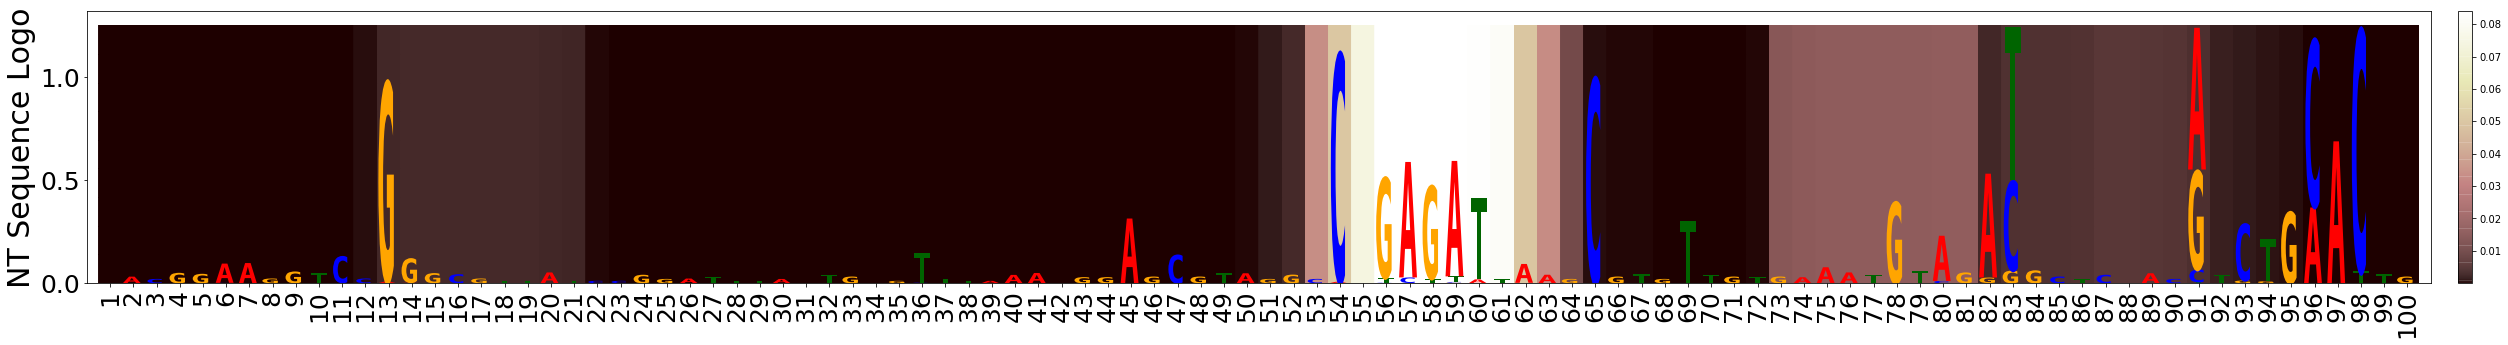

22-Aug-21 11:20:56 - Attention Visualization: Plotting Prevotella from all.


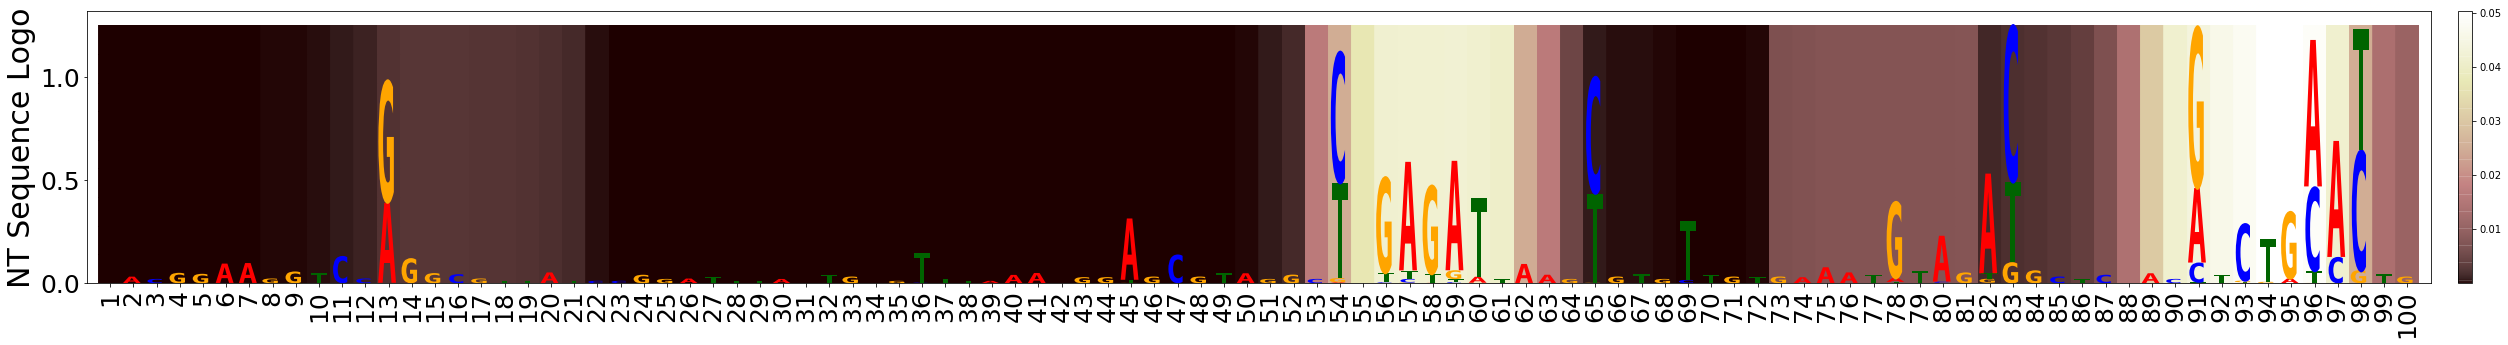

In [24]:
prediction, attention_weights, sequence_embedding = seq_att_model.extract_weigths(X_visual)
## Merge skin related classes in prediction array: simpy create a zero matrix (N by 3) 
## and assign 1 to most likely class
prediction_reduced = np.zeros((prediction.shape[0], 3))
prediction_idx = np.argmax(prediction, axis=1)
for i in range(prediction.shape[0]):
    arg_max_class = idx_to_reduced_idx[prediction_idx[i]]
    prediction_reduced[i, arg_max_class] = 1 

from sequence_attention import SeqVisualUnit
idx_to_label = {reduced_label_to_idx[label]: label for label in reduced_label_to_idx}
seq_visual_unit = SeqVisualUnit(X_visual, y_visual_reduced, idx_to_label, taxa_label_list, 
                                prediction_reduced, attention_weights, sequence_embedding, 'Figures')
seq_visual_unit.plot_embedding()
## Let's say you want to plot the attention weights of "Prevotella" reads
seq_visual_unit.plot_attention('Prevotella')

###### Note:
Currently, the plots are optimized for body site classification and Prevotella reads, but you can modify these two functions, `seq_visual_unit.plot_embedding()`, `seq_visual_unit.plot_attention`, so that it works for other applications.